In [177]:
import pandas as pd
from IPython.display import clear_output as co
import seaborn as sns; sns.set()

#### Load TER CPT

In [267]:
cpt = pd.read_excel('Conflitos de Terra-CPT-2000-2011.xlsx', sheet_name=None)['Plan1']

cpt = cpt.iloc[:-1].fillna(0)
cpt['MUN'] = cpt['MUN'].apply(lambda value: value.strip() if value.startswith(' ') else value)

# years = cpt.columns[6:]
# cpt = cpt[(cpt[years] != 0).any(axis=1)]

#### Load BASE-LENTO dataset

In [2]:
dfs = pd.read_excel('BASELEMTO_2011-2021.xlsx', sheet_name=None)

#### Load land conflicts dataset

In [114]:
land = dfs['TER-2011-2021'].iloc[:, :34].copy()

land['Município'] = land['Município'].apply(lambda value: value.replace(' D&#39', ''))
datetime_str = land['Data'].apply(lambda value: type(value)==str)
land.loc[datetime_str, 'Data'] = pd.to_datetime(land['Data'][datetime_str], dayfirst=True, yearfirst=False)

land.head(1)

,FichaLemto,Ficha,UF,Região,Bioma (ZT),Município,Geocódigo,Local,Local Secundário,Data,...,Grilagem,Incêndios,Omissão/Conivência,Impedimento de acesso a áreas de uso coletivo,Violações nas condições de existência,Soma Violências,Categoria sofreu ação,Categoria causou ação,Tipo de Violência,Eixos de Violência
0,TER-2011-2021-00006,MA1301,AC,Norte,Amazonia,Acrelândia,1200013,Assent. Califórnia/Suzano Papel e Celulose,"Assent. Califórnia/Empresas CVRD, Ferro Gusa C...",2011-05-18 00:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,Assentado,Mineradora,Danos,Terra


#### Load list of Brazilian cities in frontiers

In [115]:
frontier_cities = pd.read_html('https://pt.wikipedia.org/wiki/Lista_de_munic%C3%ADpios_fronteiri%C3%A7os_do_Brasil')

city_value_map = lambda value: value.split(' – ' if ' – ' in value else ' - ')[1]

frontier_cities = frontier_cities[2]
frontier_cities['Município'] = frontier_cities['Município'].apply(city_value_map)

frontier_cities.head()

,Município,Estado,Área territorial,População (IBGE/2007),Densidade demográfica (hab/km2),PIB (IBGE/2005,PIB per capita (R$),IDH/2000
0,Aceguá,Rio Grande do Sul,1550.0,4138.0,266,71.638.000,17.266,ni
1,Acrelândia,Acre,1575.0,11520.0,731,114.350.000,9.986,0680
2,Alecrim,Rio Grande do Sul,315.0,7357.0,2335,44.373.000,5.944,0743
3,Almeirim,Pará,72960.0,30903.0,42,462.258.000,13.485,0745
4,Alta Floresta d'Oeste,Rondônia,7067.0,23857.0,337,186.812.000,6.525,0715


---
## Sort by city and year

In [151]:
from copy import deepcopy

def multiclass_column_pivot(df, key, sep=', '):
    multiclass_list = df[key].apply(lambda value: value.split(sep)).tolist()
    df = df.copy(); n_rows = len(df)
    index = df.index.tolist()
    dup_rows, new_rows = [], []
    for i, idx in enumerate(index):
        if i%20 == 0: co(True); print(f'rows spreaded: {i+1}/{n_rows}')
        values = multiclass_list[i]
        if len(values) > 1:
            dup_rows.append(idx)
        row = df.loc[idx].copy()
        for value in values:
            row[key] = value
            new_rows.append(row.copy())
    return pd.concat(new_rows, axis=1).T.reset_index(drop=True)

key = 'Município'
df = land

df_pivot = multiclass_column_pivot(df, key, sep=', ')
df_pivot['Ano'] = pd.DatetimeIndex(df_pivot['Data']).year

sort_cols = ['Município', 'Ano', 'Data']
df_sort = pd.concat([df_pivot[sort_cols], df_pivot.drop(sort_cols, axis=1)], axis=1).sort_values(sort_cols)
df_sort.to_excel('Dados/ter-ordenado.xlsx', index=False)

df_sort.head()

rows spreaded: 2641/2648


<ipython-input-151-2038c023e99e>:27: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.2.9' currently installed).
  df_sort.to_excel('Dados/ter-ordenado.xlsx', index=False)


,Município,Ano,Data,FichaLemto,Ficha,UF,Região,Bioma (ZT),Geocódigo,Local,...,Grilagem,Incêndios,Omissão/Conivência,Impedimento de acesso a áreas de uso coletivo,Violações nas condições de existência,Soma Violências,Categoria sofreu ação,Categoria causou ação,Tipo de Violência,Eixos de Violência
3553,Abelardo Luz,2011,2011-06-06,TER-2011-2021-00001,MT310,SC,Sul,Mata Atlantica,4200101,Assentamento Santa Rosa I e II,...,NaN,NaN,NaN,NaN,NaN,NaN,Assentado,Fazendeiro,Ameaça de Morte,Terra
3562,Abelardo Luz,2012,2012-02-28,TER-2011-2021-01643,AP143,SC,Sul,Mata Atlantica,4219507,Fazenda Santa Cruz,...,NaN,NaN,NaN,NaN,NaN,NaN,Posseiro,Empresário Internacional,Intimidação,Terra
3554,Abelardo Luz,2012,2012-06-21,TER-2011-2021-00821,MT310,SC,Sul,Mata Atlantica,4200101,Assentamento Santa Rosa I e II,...,NaN,NaN,NaN,NaN,NaN,NaN,Assentado,Fazendeiro,NaN,Terra
3558,Abelardo Luz,2012,2012-06-30,TER-2011-2021-01642,AP144,SC,Sul,Mata Atlantica,4219507,Ponta do Socorro e Vareiro,...,NaN,NaN,NaN,NaN,NaN,NaN,Posseiro,Empresário,Intimidação,Terra
3555,Abelardo Luz,2012,2012-07-17,TER-2011-2021-00822,MT310,SC,Sul,Mata Atlantica,4200101,Assentamento Santa Rosa I e II,...,NaN,NaN,NaN,NaN,NaN,NaN,Assentado,Fazendeiro,NaN,Terra


---
## Count by city and year

In [144]:
col_count = 'Conflitos - TER'
count = df_sort.groupby(['Município', 'Ano']).apply(len).unstack().fillna(0)

count.to_excel('Dados/ter-serie.xlsx', index=True)
count.head()

<ipython-input-144-cf8310958c13>:4: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.2.9' currently installed).
  count.to_excel('Dados/ter-serie.xlsx', index=True)


Ano,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
Município,,,,,,,,,,,
Abelardo Luz,1.0,4.0,1.0,3.0,1.0,1.0,1.0,1.0,0.0,5.0,0.0
Acrelândia,8.0,11.0,5.0,4.0,3.0,11.0,6.0,5.0,3.0,15.0,15.0
Alenquer,0.0,0.0,0.0,0.0,2.0,3.0,1.0,0.0,1.0,2.0,1.0
Almeirim,0.0,0.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0
Alpestre,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [198]:
len(count)

238

### Yearly time serie by city

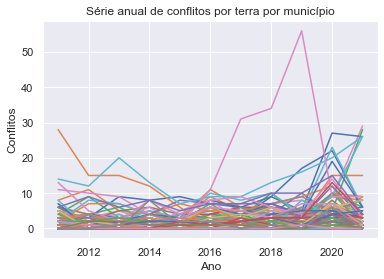

In [185]:
ax = count.T.plot(legend=[], title='Série anual de conflitos por terra por município', ylabel='Conflitos')

### Update official yearly time series

In [266]:
cpt['MUN'].values

array(["Alta Floresta D'Oeste ", 'Ariquemes ', 'Cabixi ', ...,
       'Nova Marilândia ', 'Nova Maringá ', 'Nova Monte Verde '],
      dtype=object)

In [270]:
list(set(count.index.tolist()).difference(cpt['MUN'].tolist()))

city_mapa = {
    'Diamante;Oeste',
    'Glória;Oeste',
    'Pimenteiras',
    'Alta Floresta;Oeste',
    'Alvorada;Oeste',
    'Conquista;Oeste',
    'Nova Brasilândia;Oeste',
    'Sant&#39;Ana do Livramento'    
}

['Diamante;Oeste',
 'Glória;Oeste',
 'Pimenteiras',
 'Alta Floresta;Oeste',
 'Alvorada;Oeste',
 'Conquista;Oeste',
 'Nova Brasilândia;Oeste',
 'Sant&#39;Ana do Livramento']

In [275]:
cpt['MUN'][cpt['MUN'].apply(lambda value: 'Oeste' in value)]

0          Alta Floresta D'Oeste
5              Colorado do Oeste
8                Espigão D'Oeste
12            Machadinho D'Oeste
13      Nova Brasilândia D'Oeste
14           Ouro Preto do Oeste
20           Santa Luzia D'Oeste
24              Alvorada D'Oeste
28       Novo Horizonte do Oeste
36               Itapuã do Oeste
42          Pimenteiras do Oeste
44            São Felipe D'Oeste
399            Cruzeiro do Oeste
407             Diamante D'Oeste
414          Entre Rios do Oeste
427             Formosa do Oeste
461             Iracema do Oeste
468            Itapejara d'Oeste
554          Ouro Verde do Oeste
572               Pérola d'Oeste
606        Rancho Alegre D'Oeste
635        Santa Izabel do Oeste
637         Santa Maria do Oeste
641        Santa Tereza do Oeste
654            São Jorge d'Oeste
692            Tuneiras do Oeste
702           Vera Cruz do Oeste
750           Bom Jesus do Oeste
813               Herval d'Oeste
825               Iporã do Oeste
923       

In [250]:
count.index.values

array(['Abelardo Luz', 'Acrelândia', 'Alenquer', 'Almeirim', 'Alpestre',
       'Alta Floresta;Oeste', 'Alto Alegre', 'Alto Alegre dos Parecis',
       'Alto Paraíso', 'Alvorada;Oeste', 'Amajari', 'Amambai', 'Amapá',
       'Amaturá', 'Anastácio', 'Antônio João', 'Aquidauana',
       'Aral Moreira', 'Ariquemes', 'Arvoredo', 'Assis Brasil',
       'Atalaia do Norte', 'Bagé', 'Barcelos', 'Barra do Bugres',
       'Barão de Melgaço', 'Bela Vista', 'Benjamin Constant',
       'Benjamin Constant do Sul', 'Boa Vista', 'Boca do Acre', 'Bonfim',
       'Bonito', 'Brasiléia', 'Bujari', 'Buritis', 'Caarapó', 'Cabixi',
       'Cacaulândia', 'Cachoeira do Sul', 'Calçoene', 'Campo Grande',
       'Campo Novo de Rondônia', 'Campo Novo do Parecis',
       'Campos de Júlio', 'Candiota', 'Cantá', 'Canutama', 'Capanema',
       'Capitão Leônidas Marques', 'Capixaba', 'Capão do Leão',
       'Caracaraí', 'Carazinho', 'Caroebe', 'Cascavel', 'Catuípe',
       'Caçapava do Sul', 'Cerejeiras', 'Chapecó', 'Ch